In [ ]:
"""
Project1 : Stock Trade Outlier Analysis using Graph Database

Objectives:
    Develop an FX Trade Analysis System – Build a system to analyze foreign exchange (FX) trades and detect anomalies.
    
    Construct a Graph-Based Trade Model – Store FX trade data in a Neo4j graph database, representing trades as nodes and relationships between them as edges.
    
    Identify Outliers in Trading Patterns – Implement statistical methods (Z-score, IQR) to detect unusual trades based on trade volume, price, and timestamp.
    
    Compare Actual Trades with Expected Guidelines – Define trade pattern benchmarks and identify deviations from expected behavior.
    
    Visualize and Report Insights – Generate interactive visualizations and summary reports highlighting trade outliers and deviations.
    

"""

In [1]:
##step1 : Install libraries ##
!pip install neo4j pandas numpy networkx matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
##Step 2: Connect to Neo4j Database##

from neo4j import GraphDatabase

# Neo4j connection details
URL = "bolt://localhost:7687"  
USERNAME = "neo4j"
PASSWORD = "password"

# Connect to Neo4j
driver = GraphDatabase.driver(URL, auth=(USERNAME, PASSWORD))

print("Connected to Neo4j successfully!")




Connected to Neo4j successfully!


In [3]:
import pandas as pd
import numpy as np

# Generate sample trade data
np.random.seed(42)

num_rows = 15  # Ensure all columns have 15 rows

data = {
    "trade_id": range(1, num_rows + 1),
    "currency_pair": ["EUR/USD"] * 7 + ["GBP/USD"] * 8,
    "volume": np.concatenate((
        np.random.randint(5000, 20000, num_rows - 4),  # Normal trade volumes
        [50000, 100000, 200, 300]  # Outlier volumes
    )),
    "price": np.round(np.concatenate((
        np.random.uniform(1.1, 1.3, num_rows - 4),  # Normal prices
        [1.5, 0.8, 1.6, 0.7]  # Outlier prices
    )), 4),
    "timestamp": pd.date_range("2024-02-01", periods=num_rows, freq="h")  # Use "h" instead of "H"
}

# Convert to DataFrame
df = pd.DataFrame(data)

print(df)


    trade_id currency_pair  volume   price           timestamp
0          1       EUR/USD   12270  1.1116 2024-02-01 00:00:00
1          2       EUR/USD    5860  1.2732 2024-02-01 01:00:00
2          3       EUR/USD   10390  1.2202 2024-02-01 02:00:00
3          4       EUR/USD   18418  1.2416 2024-02-01 03:00:00
4          5       EUR/USD   10191  1.1041 2024-02-01 04:00:00
5          6       EUR/USD   16964  1.2940 2024-02-01 05:00:00
6          7       EUR/USD   16284  1.2665 2024-02-01 06:00:00
7          8       GBP/USD   10734  1.1425 2024-02-01 07:00:00
8          9       GBP/USD   11265  1.1364 2024-02-01 08:00:00
9         10       GBP/USD    5466  1.1367 2024-02-01 09:00:00
10        11       GBP/USD   18526  1.1608 2024-02-01 10:00:00
11        12       GBP/USD   50000  1.5000 2024-02-01 11:00:00
12        13       GBP/USD  100000  0.8000 2024-02-01 12:00:00
13        14       GBP/USD     200  1.6000 2024-02-01 13:00:00
14        15       GBP/USD     300  0.7000 2024-02-01 1

In [4]:
##Step 4: Insert Data into Neo4j##

def insert_trade(tx, trade):
    query = """
    CREATE (t:Trade {trade_id: $trade_id, currency_pair: $currency_pair, 
                     volume: $volume, price: $price, timestamp: $timestamp})
    """
    tx.run(query, **trade)

# Insert each row from DataFrame into Neo4j
with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(insert_trade, row.to_dict())

print("Inserted trades into Neo4j!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_16788\3596081073.py:13: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_trade, row.to_dict())


Inserted trades into Neo4j!


In [5]:
##Step 5: Create Relationships Between Trades##

def create_relationships(tx):
    query = """
    MATCH (t1:Trade), (t2:Trade) 
    WHERE t1.timestamp < t2.timestamp
    CREATE (t1)-[:NEXT_TRADE]->(t2)
    """
    tx.run(query)

with driver.session() as session:
    session.write_transaction(create_relationships)

print("Created relationships between consecutive trades!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_16788\382499192.py:12: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_relationships)


Created relationships between consecutive trades!


In [6]:
###Step 6: Detect Outliers Using Z-Score##
!pip install scipy

from scipy.stats import zscore

# Compute Z-scores for trade volume
df["volume_zscore"] = zscore(df["volume"])

# Define outliers: Z-score > 2 or < -2
df["is_outlier"] = df["volume_zscore"].abs() > 2

print(df[["trade_id", "volume", "volume_zscore", "is_outlier"]])


    trade_id  volume  volume_zscore  is_outlier
0          1   12270      -0.281119       False
1          2    5860      -0.544006       False
2          3   10390      -0.358222       False
3          4   18418      -0.028976       False
4          5   10191      -0.366383       False
5          6   16964      -0.088608       False
6          7   16284      -0.116496       False
7          8   10734      -0.344113       False
8          9   11265      -0.322336       False
9         10    5466      -0.560165       False
10        11   18526      -0.024547       False
11        12   50000       1.266268       False
12        13  100000       3.316873        True
13        14     200      -0.776135       False
14        15     300      -0.772034       False


In [7]:
def mark_outliers(tx, trade_id, is_outlier):
    query = """
    MATCH (t:Trade {trade_id: $trade_id})
    SET t.is_outlier = $is_outlier
    """
    tx.run(query, trade_id=int(trade_id), is_outlier=bool(is_outlier))  # Ensure correct types

with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(mark_outliers, row["trade_id"], row["is_outlier"])

print("Marked outliers in Neo4j!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_16788\226186190.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(mark_outliers, row["trade_id"], row["is_outlier"])


Marked outliers in Neo4j!


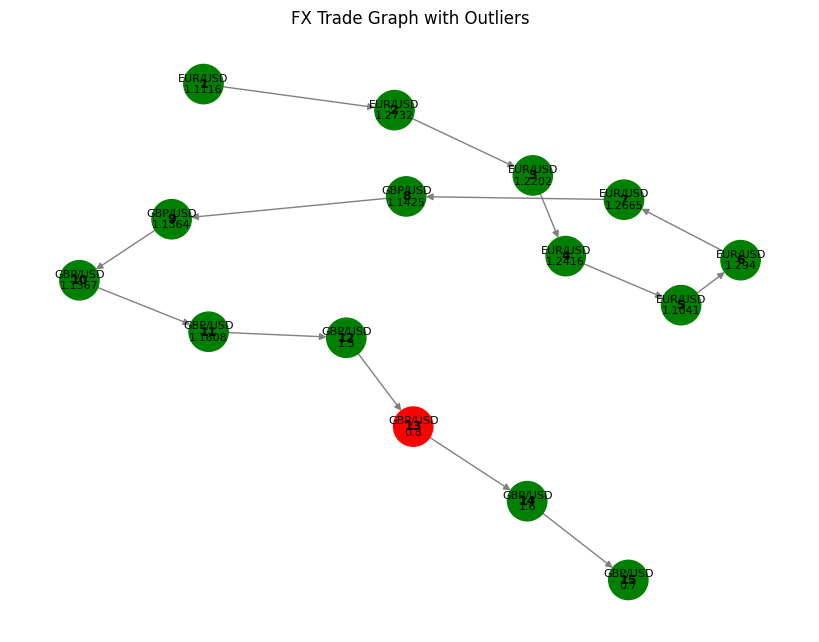

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()

# Add nodes (trades)
for _, row in df.iterrows():
    color = "red" if row["is_outlier"] else "green"
    G.add_node(row["trade_id"], color=color, label=f"{row['currency_pair']}\n{row['price']}")

# Add edges (NEXT_TRADE relationships)
for i in range(len(df) - 1):
    G.add_edge(df.loc[i, "trade_id"], df.loc[i+1, "trade_id"])

# Draw graph
pos = nx.spring_layout(G, seed=42)  # Ensure consistent layout
colors = [G.nodes[n]["color"] for n in G.nodes]
labels = {n: G.nodes[n]["label"] for n in G.nodes}

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=colors, edge_color="gray", node_size=800, font_size=9, font_weight="bold")
nx.draw_networkx_labels(G, pos, labels, font_size=8, verticalalignment='center')
plt.title("FX Trade Graph with Outliers", fontsize=12)
plt.show()

In [1]:
#!pip install streamlit networkx matplotlib pandas numpy
!pip install gradio


In [3]:
import gradio as gr
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate sample trade data
np.random.seed(42)
num_rows = 15  # Ensure all columns have 15 rows
data = {
    "trade_id": range(1, num_rows + 1),
    "currency_pair": ["EUR/USD"] * 7 + ["GBP/USD"] * 8,
    "volume": np.concatenate((
        np.random.randint(5000, 20000, num_rows - 4),  # Normal trade volumes
        [50000, 100000, 200, 300]  # Outlier volumes
    )),
    "price": np.round(np.concatenate((
        np.random.uniform(1.1, 1.3, num_rows - 4),  # Normal prices
        [1.5, 0.8, 1.6, 0.7]  # Outlier prices
    )), 4),
    "timestamp": pd.date_range("2024-02-01", periods=num_rows, freq="h")  # Use "h" instead of "H"
}

df = pd.DataFrame(data)

# Compute Z-scores for trade volume
df["volume_zscore"] = (df["volume"] - df["volume"].mean()) / df["volume"].std()
df["is_outlier"] = df["volume_zscore"].abs() > 2

def plot_graph():
    # Create graph
    G = nx.DiGraph()

    # Add nodes (trades)
    for _, row in df.iterrows():
        color = "red" if row["is_outlier"] else "green"
        G.add_node(row["trade_id"], color=color, label=f"{row['currency_pair']}\n{row['price']}")

    # Add edges (NEXT_TRADE relationships)
    for i in range(len(df) - 1):
        G.add_edge(df.loc[i, "trade_id"], df.loc[i+1, "trade_id"])

    # Draw graph
    pos = nx.spring_layout(G, seed=42)
    colors = [G.nodes[n]["color"] for n in G.nodes]
    labels = {n: G.nodes[n]["label"] for n in G.nodes}

    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=colors, edge_color="gray", node_size=800, font_size=9, font_weight="bold", ax=ax)
    nx.draw_networkx_labels(G, pos, labels, font_size=8, verticalalignment='center', ax=ax)
    plt.title("FX Trade Graph with Outliers", fontsize=12)
    return fig

def show_data():
    return df

gui = gr.Interface(
    fn=plot_graph,
    inputs=[],
    outputs=gr.Plot(),
    live=False,
    title="FX Trade Graph with Outliers"
)

data_table = gr.Interface(
    fn=show_data,
    inputs=[],
    outputs=gr.Dataframe(),
    title="Trade Data Table"
)

demo = gr.TabbedInterface([gui, data_table], ["Graph", "Data Table"])

demo.launch()


* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
